In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import kagglehub
path=kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")
print("Path to dataset files:",path)

Path to dataset files: /kaggle/input/brain-tumor-mri-dataset


In [2]:
import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]="1.00" 
os.environ["TF_GPU_ALLOCATOR"]="cuda_malloc_async"

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_path='/kaggle/input/brain-tumor-mri-dataset/Training'
test_path='/kaggle/input/brain-tumor-mri-dataset/Testing'

2025-08-09 18:40:44.778038: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754764844.801211     793 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754764844.807933     793 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
train_datagen=ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

In [5]:
val_test_datagen=ImageDataGenerator(
    rescale=1.0/255,
    validation_split=0.2
)

In [6]:
train_data=train_datagen.flow_from_directory(
    train_path,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    subset='training'
)

Found 4571 images belonging to 4 classes.


In [7]:
val_data=val_test_datagen.flow_from_directory(
    train_path,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False,
    subset='validation'
)

Found 1141 images belonging to 4 classes.


In [8]:
test_data=val_test_datagen.flow_from_directory(
    test_path,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 1311 images belonging to 4 classes.


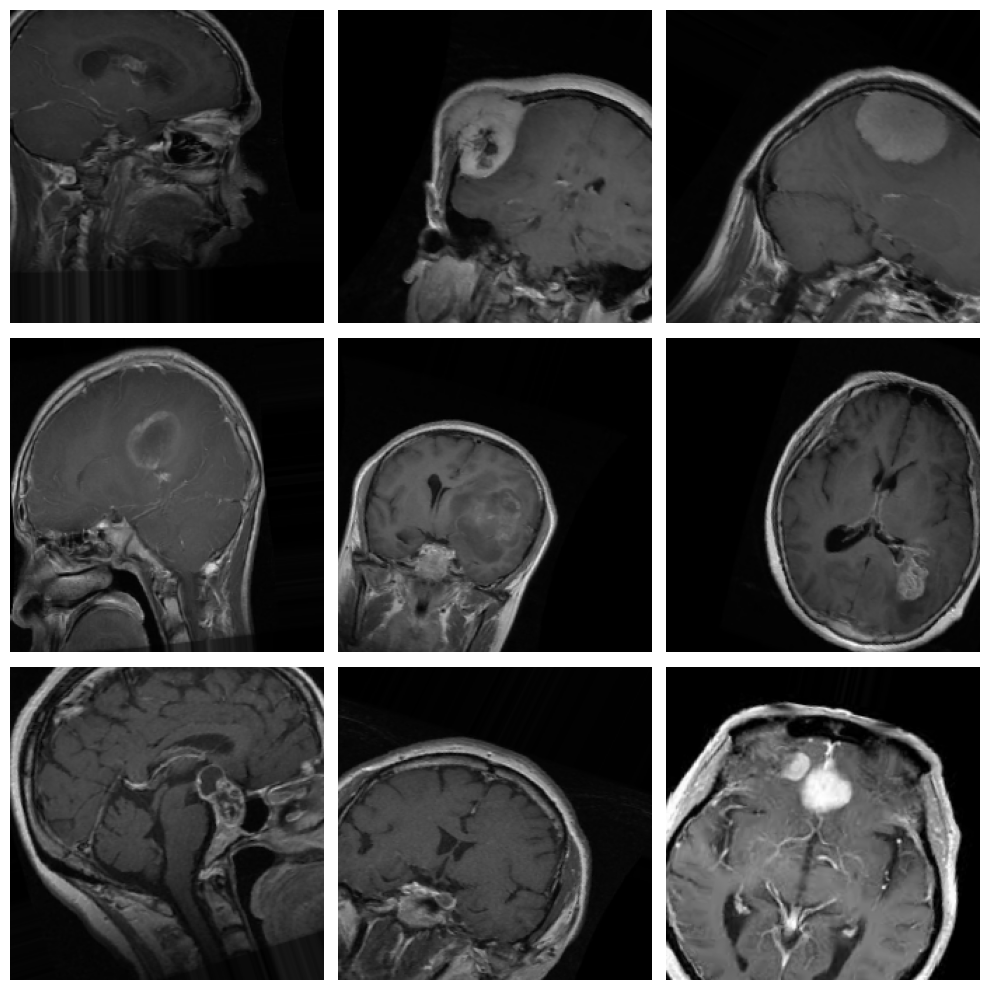

In [9]:
import matplotlib.pyplot as plt
sample_images,sample_labels=next(train_data)
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(sample_images[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

In [10]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
class_weights=compute_class_weight(class_weight='balanced',classes=np.unique(train_data.classes),y=train_data.classes)
class_weights_dict=dict(enumerate(class_weights))

In [11]:
print(class_weights_dict)

{0: 1.0811258278145695, 1: 1.0659981343283582, 2: 0.8955721003134797, 3: 0.9800600343053173}


In [12]:
from tensorflow.keras import layers,models,Model,Input
from tensorflow.keras.applications import Xception
base_model=Xception(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)

I0000 00:00:1754764850.650939     793 gpu_process_state.cc:201] Using CUDA malloc Async allocator for GPU: 0
I0000 00:00:1754764850.651297     793 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [13]:
base_model.trainable=False

In [14]:
model=models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024,activation='silu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(512,activation='silu'),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Dense(256,activation='silu'),
    layers.Dropout(0.3),
    layers.Dense(4,activation='softmax')
])

In [15]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 7, 7, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,622,956 (90.11 MB)

 Trainable params: 2,758,404 (10.52 MB)

 Non-trainable params: 20,864,552 (79.59 MB)

In [16]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC,TopKCategoricalAccuracy
model.compile(optimizer=Adam(learning_rate=1e-4),loss='categorical_crossentropy',metrics=['accuracy',AUC(name='auc'),TopKCategoricalAccuracy(k=1,name='top_1_accuracy')])

In [17]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopper=EarlyStopping(patience=5,monitor='val_loss',restore_best_weights=True)

In [18]:
history=model.fit(train_data,validation_data=val_data,epochs=30,batch_size=32,callbacks=[early_stopper],verbose=1,class_weight=class_weights_dict)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30


I0000 00:00:1754764862.425233     869 service.cc:148] XLA service 0x7c3ed4013280 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1754764862.425270     869 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1754764863.529077     869 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/143 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - accuracy: 0.3438 - auc: 0.5551 - loss: 2.0518 - top_1_accuracy: 0.3438 

I0000 00:00:1754764869.713676     869 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


143/143 ━━━━━━━━━━━━━━━━━━━━ 85s 486ms/step - accuracy: 0.5439 - auc: 0.7904 - loss: 1.2136 - top_1_accuracy: 0.5439 - val_accuracy: 0.7152 - val_auc: 0.8952 - val_loss: 0.8828 - val_top_1_accuracy: 0.7152
Epoch 2/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 57s 395ms/step - accuracy: 0.7751 - auc: 0.9374 - loss: 0.6390 - top_1_accuracy: 0.7751 - val_accuracy: 0.7239 - val_auc: 0.9163 - val_loss: 0.7019 - val_top_1_accuracy: 0.7239
Epoch 3/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 55s 386ms/step - accuracy: 0.7975 - auc: 0.9517 - loss: 0.5616 - top_1_accuracy: 0.7975 - val_accuracy: 0.7493 - val_auc: 0.9366 - val_loss: 0.6298 - val_top_1_accuracy: 0.7493
Epoch 4/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 56s 389ms/step - accuracy: 0.8225 - auc: 0.9606 - loss: 0.4998 - top_1_accuracy: 0.8225 - val_accuracy: 0.7625 - val_auc: 0.9382 - val_loss: 0.6593 - val_top_1_accuracy: 0.7625
Epoch 5/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 55s 387ms/step - accuracy: 0.8392 - auc: 0.9668 - loss: 0.4561 - top_1_accuracy: 0.8392 - val_accuracy:

In [19]:
base_model.trainable=True

In [20]:
model.compile(optimizer=Adam(learning_rate=1e-5),loss='categorical_crossentropy',metrics=['accuracy',AUC(name='auc'),TopKCategoricalAccuracy(k=1,name='top_1_accuracy')])

In [21]:
history=model.fit(train_data,validation_data=val_data,epochs=15,batch_size=32,callbacks=[early_stopper],verbose=1,class_weight=class_weights_dict)

Epoch 1/15


E0000 00:00:1754765926.223845     869 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1754765926.434094     869 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1754765927.503613     869 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1754765927.694262     869 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1754765928.611645     869 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

106/143 ━━━━━━━━━━━━━━━━━━━━ 14s 393ms/step - accuracy: 0.6833 - auc: 0.8975 - loss: 0.8971 - top_1_accuracy: 0.6833

E0000 00:00:1754765991.191505     867 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1754765991.398436     867 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1754765992.359640     867 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1754765992.550308     867 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1754765993.388202     867 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

143/143 ━━━━━━━━━━━━━━━━━━━━ 148s 612ms/step - accuracy: 0.7020 - auc: 0.9064 - loss: 0.8478 - top_1_accuracy: 0.7020 - val_accuracy: 0.7528 - val_auc: 0.9303 - val_loss: 0.7991 - val_top_1_accuracy: 0.7528
Epoch 2/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 60s 418ms/step - accuracy: 0.8397 - auc: 0.9653 - loss: 0.4812 - top_1_accuracy: 0.8397 - val_accuracy: 0.7642 - val_auc: 0.9352 - val_loss: 0.6861 - val_top_1_accuracy: 0.7642
Epoch 3/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 59s 414ms/step - accuracy: 0.8738 - auc: 0.9752 - loss: 0.3850 - top_1_accuracy: 0.8738 - val_accuracy: 0.7730 - val_auc: 0.9435 - val_loss: 0.6215 - val_top_1_accuracy: 0.7730
Epoch 4/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 59s 412ms/step - accuracy: 0.9002 - auc: 0.9840 - loss: 0.3023 - top_1_accuracy: 0.9002 - val_accuracy: 0.8247 - val_auc: 0.9587 - val_loss: 0.5111 - val_top_1_accuracy: 0.8247
Epoch 5/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 60s 419ms/step - accuracy: 0.8961 - auc: 0.9816 - loss: 0.3191 - top_1_accuracy: 0.8961 - val_accuracy

In [22]:
test_loss,test_accuracy,test_auc,test_top1=model.evaluate(test_data,verbose=1)
print(f"\nTest Accuracy:{test_accuracy*100:.4f}%")
print(f"Test AUC:{test_auc*100:.4f}%")
print(f"Top-1 Test Accuracy:{test_top1*100:.4f}%")

41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 201ms/step - accuracy: 0.9170 - auc: 0.9891 - loss: 0.2221 - top_1_accuracy: 0.9170

Test Accuracy:93.5927%
Test AUC:99.2380%
Top-1 Test Accuracy:93.5927%


In [23]:
val_loss,val_accuracy,val_auc,val_top1=model.evaluate(val_data,verbose=1)
print(f"\nValidation Accuracy:{val_accuracy*100:.4f}%")
print(f"Validation AUC:{val_auc*100:.4f}%")
print(f"Top-1 Validation Accuracy:{val_top1*100:.4f}%")

36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - accuracy: 0.9038 - auc: 0.9886 - loss: 0.2279 - top_1_accuracy: 0.9038

Validation Accuracy:90.6223%
Validation AUC:98.7177%
Top-1 Validation Accuracy:90.6223%


In [24]:
import numpy as np
y_pred=model.predict(test_data)
y_pred_class=np.argmax(y_pred,axis=1)
y_true=test_data.classes

41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step


In [25]:
from sklearn.metrics import precision_score,recall_score,f1_score,accuracy_score,classification_report,confusion_matrix

accuracy=accuracy_score(y_true,y_pred_class)
precision=precision_score(y_true,y_pred_class,average='weighted')
recall=recall_score(y_true,y_pred_class,average='weighted')
f1=f1_score(y_true,y_pred_class,average='weighted')

print("\nPerformance Metrics Breakdown:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")


Performance Metrics Breakdown:
Accuracy: 0.9359
Precision: 0.9366
Recall: 0.9359
F1-Score: 0.9354


In [26]:
class_labels=list(val_data.class_indices.keys())

In [27]:
print("Classification Report:")
print(classification_report(y_true,y_pred_class,target_names=class_labels))

Classification Report:
              precision    recall  f1-score   support

      glioma       0.93      0.91      0.92       300
  meningioma       0.92      0.85      0.88       306
     notumor       0.99      0.98      0.99       405
   pituitary       0.89      0.99      0.94       300

    accuracy                           0.94      1311
   macro avg       0.93      0.93      0.93      1311
weighted avg       0.94      0.94      0.94      1311



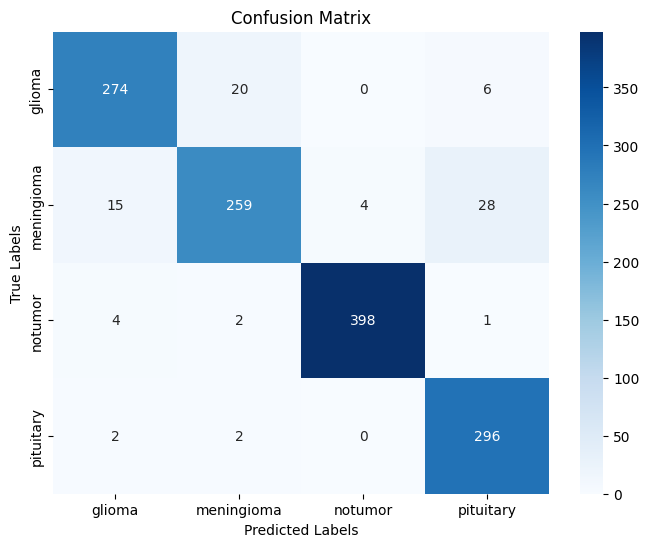

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
cm=confusion_matrix(y_true,y_pred_class)
plt.figure(figsize=(8,6))
sns.heatmap(cm,annot=True,fmt='d',cmap='Blues',xticklabels=class_labels,yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

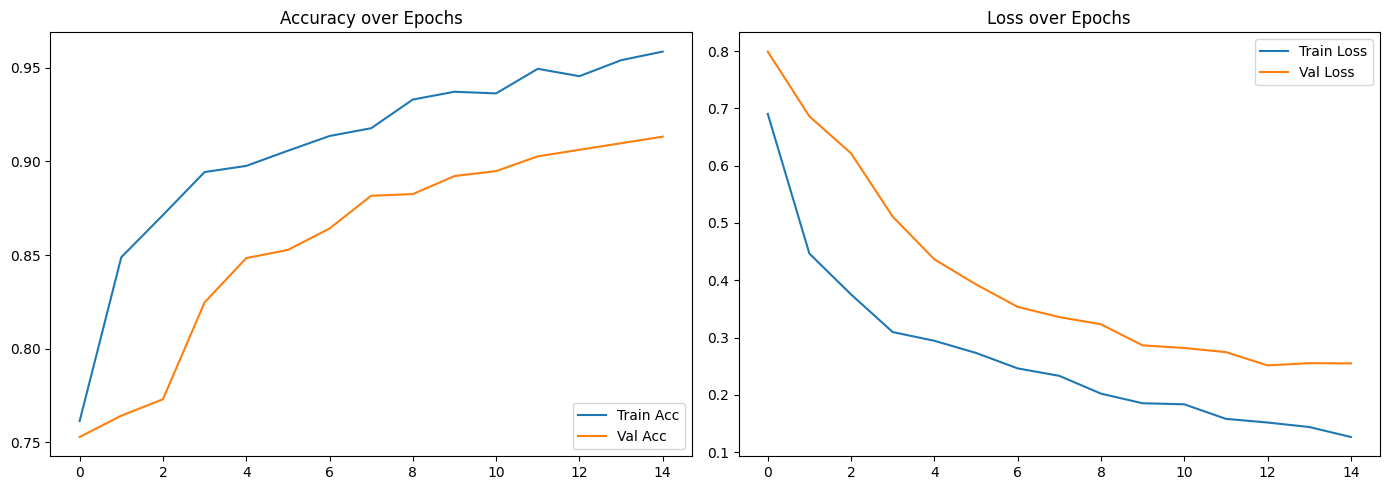

In [29]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']
epochs_range=range(len(acc))

plt.figure(figsize=(14,5))


plt.subplot(1,2,1)
plt.plot(epochs_range,acc,label='Train Acc')
plt.plot(epochs_range,val_acc,label='Val Acc')
plt.legend(loc='lower right')
plt.title('Accuracy over Epochs')


plt.subplot(1,2,2)
plt.plot(epochs_range,loss,label='Train Loss')
plt.plot(epochs_range,val_loss,label='Val Loss')
plt.legend(loc='upper right')
plt.title('Loss over Epochs')

plt.tight_layout()
plt.savefig("training_curves.png")
plt.show()

In [30]:
from tensorflow.keras.models import save_model
save_model(model,'brain_tumor_Xception.h5')